In [1]:
# !pip install shap

In [1]:
import pandas as pd
import numpy as np
import random
import os
import math
from tqdm import tqdm

import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, accuracy_score

/home/user/anaconda3/envs/bsh/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils & preprocess

X = (batch, dimension, sequence)<br>
dimension은 feature 수 , sequence는 timestamp

y = (0,1) <br>
0 = healthy, 1 = failure

In [2]:
def extract_sequences(df, sequence_length, stride = 1 , next_time = True ):
    data_x = []
    assign_nums = df['배정번호'].unique()
    for assign_num in tqdm(assign_nums, total=len(assign_nums), desc='배정번호 별로 추출하는중'):
        sampled_labeled_df = df[df['배정번호']==assign_num]
        sampled_labeled_df = sampled_labeled_df.reset_index(drop=True)
        start_idx = 0
        while start_idx + sequence_length <= len(sampled_labeled_df):
            end_idx = start_idx + sequence_length
            sub_df = sampled_labeled_df.iloc[start_idx:end_idx]
            time_diff = (sub_df['TAG_MIN'].max() - sub_df['TAG_MIN'].min()).seconds
            if time_diff == sequence_length - 1:
                sequence = sub_df.drop(columns=['TAG_MIN', '배정번호','불량여부']).values
                data_x.append(sequence)
                if next_time == True:
                    start_idx = end_idx
                else:
                    start_idx += stride
            else:
                start_idx += stride
    return np.stack(data_x, axis=0)

In [3]:
def make_dataset(data , quality, threshold = 0.1, sequence_length = 60, downsampling = 2000):

    quality['불량률'] = quality['불량수량']/ quality['총수량'] * 100
    quality['불량여부'] = quality['불량률'].apply(lambda x: 1 if x > threshold else 0)
    labeled_df = data.merge(quality[['배정번호','불량여부']], on='배정번호', how='left')
    labeled_df['TAG_MIN'] =pd.to_datetime(labeled_df.TAG_MIN, format='%Y-%m-%d %H:%M:%S')
    labeled_df = labeled_df.dropna() # 지금은 결측치가 있는 행을 제거
    labeled_df_healthy = labeled_df[labeled_df['불량여부']==0]
    labeled_df_failure = labeled_df[labeled_df['불량여부']==1]
    healthy_x = extract_sequences(labeled_df_healthy, sequence_length , stride = 1, next_time = True)
    failure_x = extract_sequences(labeled_df_failure, sequence_length , stride = 1, next_time = True)
    random_indices = np.random.choice(healthy_x.shape[0], downsampling, replace=False)
    healthy_x = healthy_x[random_indices]
    healthy_y = np.zeros(len(healthy_x))
    failure_y = np.ones(len(failure_x))
    x_data = np.concatenate((healthy_x, failure_x), axis=0)
    y_data = np.concatenate((healthy_y, failure_y), axis=0)
    x_data, y_data = shuffle(x_data, y_data, random_state=42)
    return x_data, y_data

In [4]:
def Scaler_split(x_data, y_data,sequence_length = 60):

    number = list(range(1, len(x_data)))
    random.shuffle(number)
    train_ratio = 0.6
    valid_ratio = 0.2

    total_len = len(x_data)
    train_len = int(total_len * train_ratio)
    valid_len = int(total_len * valid_ratio)

    train_num = number[:train_len]
    valid_num = number[train_len:train_len+valid_len]
    test_num = number[train_len+valid_len:]

    X_train = x_data[train_num].reshape((-1,19))
    X_valid = x_data[valid_num].reshape((-1,19))
    X_test = x_data[test_num].reshape((-1,19))

    y_train = y_data[train_num]
    y_valid = y_data[valid_num]
    y_test = y_data[test_num]

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train).reshape((-1,sequence_length,19))
    X_valid = scaler.transform(X_valid).reshape((-1,sequence_length,19))
    X_test = scaler.transform(X_test).reshape((-1,sequence_length,19))

    X_train = X_train.transpose((0,2,1))
    X_valid = X_valid.transpose((0,2,1))
    X_test = X_test.transpose((0,2,1))

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [5]:
class MyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [6]:
def plot_losses(train_losses, valid_losses, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    plt.title('Train and Validation Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [7]:
def plot_accuracies(train_accuracies, valid_accuracies, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
    plt.title('Train and Validation Accuracies over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [8]:
def test(model, test_loader):
    model.eval()

    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(device)
            y_data_batch = y_data_batch.to(device)

            probabilities = model(x_data_batch)[:, 1]
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(y_data_batch.cpu().numpy())

    all_predictions = [1 if prob > 0.5 else 0 for prob in all_probabilities]

    f1 = f1_score(all_labels, all_predictions, average='macro')
    auroc = roc_auc_score(all_labels, all_probabilities)
    accuracy = accuracy_score(all_labels, all_predictions)

    return f1, auroc, accuracy, all_labels, all_probabilities

In [9]:
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, linestyle='-', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Model

In [10]:
# 뒷 padding 제거
class Chomp1d(torch.nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size]

In [11]:
class CausalConvolutionBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,dilation, final = False):
        super().__init__()

        padding = (kernel_size - 1) * dilation

        conv1 = nn.utils.weight_norm(nn.Conv1d(in_channels, out_channels, kernel_size, padding = padding, dilation = dilation))
        chomp1 = Chomp1d(padding)
        relu1 = nn.LeakyReLU()

        conv2 = nn.utils.weight_norm(nn.Conv1d(out_channels, out_channels, kernel_size, padding = padding, dilation = dilation))
        chomp2 = Chomp1d(padding)
        relu2 = nn.LeakyReLU()

        # Causal network
        self.causal = torch.nn.Sequential(
            conv1, chomp1, relu1, conv2, chomp2, relu2
        )

        # Residual connection
        self.upordownsample = torch.nn.Conv1d(
            in_channels, out_channels, 1
        ) if in_channels != out_channels else None

        # Final activation function
        self.relu = torch.nn.LeakyReLU() if final else None

    def forward(self, x):
        out_causal = self.causal(x)
        res = x if self.upordownsample is None else self.upordownsample(x)
        if self.relu is None:
            return out_causal + res
        else:
            return self.relu(out_causal + res)


In [12]:
class CausalCNN(torch.nn.Module):
    def __init__(self, in_channels, channels, depth, out_channels,
                 kernel_size):
        super(CausalCNN, self).__init__()

        layers = []  # layer of convolution block
        dilation_size = 1  # initial setting

        for i in range(depth):
            in_channels_block = in_channels if i == 0 else channels
            layers += [CausalConvolutionBlock(
                in_channels_block, channels, kernel_size, dilation_size
            )]
            dilation_size *= 2  # 각 step이 지날수록 dilation이 2배로

        # last layer
        layers += [CausalConvolutionBlock(
            channels, out_channels, kernel_size, dilation_size
        )]

        self.network = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [13]:
class SqueezeChannels(torch.nn.Module):
    def __init__(self):
        super(SqueezeChannels, self).__init__()

    def forward(self, x):
        return x.squeeze(2)

In [14]:
class CausalCNNEncoder(torch.nn.Module):
    '''
    (1,10,1056) tensor를 넣는다고 하자
    Causal_cnn(10,10,5,5,3)을 거치면 (1, 5, 1056)가 된다.
    AdaptiveMaxPool1d(1) 를 거치면 (1,5,1)이 된다.
    SqueezeChannels() 을 거치면 (1,5)가 된다.
    그 다음은 linear거쳐서 (1,2)가 되게 하고 이진 분류를 하면 된다.(마무리!!!!!!)
    '''
    def __init__(self, config):
        super(CausalCNNEncoder, self).__init__()
        causal_cnn = CausalCNN(
            config.in_channels, config.channels, config.depth, config.reduced_size, config.kernel_size
        )
        reduce_size = torch.nn.AdaptiveMaxPool1d(1)
        squeeze = SqueezeChannels()  # Squeezes the third dimension (time)
        linear = torch.nn.Linear(config.reduced_size, config.out_channels)
        self.network = torch.nn.Sequential(
            causal_cnn, reduce_size, squeeze, linear
        )

    def forward(self, x):
        return self.network(x.float())

# trainer 구현

In [15]:
class Trainer():
  def __init__(self, model, optimizer, loss_function, device):
    super().__init__()
    self.model = model
    self.optimizer = optimizer
    self.loss_function = loss_function
    self.device = device

  def train(self, train_loader, config):
    self.model.train()

    total_loss = 0
    total_correct = 0

    batch_size = train_loader.batch_size
    total_dataset_size = len(train_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    for batch in tqdm( train_loader, total = num_batches ):
      self.optimizer.zero_grad()

      x_data_batch, y_data_batch = batch

      x_data_batch = x_data_batch.to(self.device)
      y_data_batch = y_data_batch.to(self.device)

      outputs = self.model(x_data_batch)
      loss = self.loss_function(outputs, y_data_batch.long())
      total_loss += loss.item()

      #역전파
      loss.backward()
      self.optimizer.step()

      _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
      correct = (predicted == y_data_batch).sum().item()
      total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def valid(self, valid_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = valid_loader.batch_size
    total_dataset_size = len(valid_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(valid_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def test(self, test_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = test_loader.batch_size
    total_dataset_size = len(test_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(test_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def save_model(self, epoch, path="model_checkpoint"):
    model_path = f"{path}_epoch_{epoch}.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")

  def save_best_model(self, path="model_checkpoint"):
    model_path = f"{path}_best_model.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")

# Main

In [16]:
class Config():
  threshold = 0.1        # 불량률을 몇 퍼센트까지 0.1로 정의할 것인지
  sequence_length = 60   # 몇초를 하나의 instance로 볼 것인지
  downsampling = 4000    # healthy data를 몇개를 쓸지
  EPOCH = 200
  LEARNING_RATE = 0.001
  BATCH_SIZE = 256
  SEED = 42
  in_channels = 19       # 처음 input의 차원의 개수 (feature수와 같다)
  channels = 19          # 중간의 차원
  depth = 5              # block 개수, block이 2이면 dilation도 2까지 한다고 생각하면 된다.
  reduced_size = 10      # 여러 block을 다 지나고 나온 차원의 개수
  out_channels = 2       # block거치고 linear 변환을 마친 차원의 개수, 여기가 2이면 이진분류
  kernel_size = 3        # kernel size인데 CasualCNNEncoder의 모든 커널의 size는 같다.

config = Config()

In [17]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.SEED) # Seed 고정

In [18]:
df = pd.read_csv('/home/user/Desktop/bsh/absoluteA/data/data.csv',encoding = 'cp949')
quality = pd.read_excel('/home/user/Desktop/bsh/absoluteA/data/quality.xlsx')

In [19]:
# 정의한 기준에 맞게 label하고 정해준 시간만큼 split하고 dataset만들기
x_data, y_data = make_dataset(df,quality , threshold = config.threshold, sequence_length = config.sequence_length, downsampling = config.downsampling )

배정번호 별로 추출하는중: 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


In [20]:
print('healthy(0)의 개수 :',int(len(y_data)-y_data.sum()))
print('failure(1)의 개수 :',int(y_data.sum()))

healthy(0)의 개수 : 4000
failure(1)의 개수 : 1569


In [21]:
X_train, X_valid, X_test, y_train, y_valid, y_test = Scaler_split(x_data, y_data, sequence_length = config.sequence_length)

In [22]:
# 인스턴스 생성
train_dataset = MyDataset(X_train, y_train)
valid_dataset = MyDataset(X_valid, y_valid)
test_dataset = MyDataset(X_test, y_test)

del X_train, X_valid, X_test, y_train, y_valid, y_test

In [23]:
# batch로 분할
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

In [24]:
#데이터 수 확인
total_train_data = len(train_loader.dataset)
print(f"Total number of data samples in train_loader: {total_train_data}")
total_valid_data = len(valid_loader.dataset)
print(f"Total number of data samples in valid_loader: {total_valid_data}")
total_test_data = len(test_loader.dataset)
print(f"Total number of data samples in test_loader: {total_test_data}")

Total number of data samples in train_loader: 3341
Total number of data samples in valid_loader: 1113
Total number of data samples in test_loader: 1114


In [25]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [26]:
# model, optimizer, loss_function 구현하고 결합시키기
model = CausalCNNEncoder(config)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_function, device)

In [27]:
# save path 지정 잘해줄 것!!!!!!!!(일단 지금은 저장하지 말자)
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
valid_accuracy_save = 0
best_epoch_save = 0 

for epoch in range(config.EPOCH):
    print('=====================================================================================')
    print("epoch {}".format(epoch+1))

    train_loss, train_accuracy = trainer.train(train_loader, config)
    valid_loss, valid_accuracy = trainer.valid(valid_loader, config)
    if valid_accuracy_save < valid_accuracy :
      trainer.save_best_model(path = '/home/user/Desktop/bsh/absoluteA/model/4000_tcn') # 이 부분!!!!
      valid_accuracy_save = valid_accuracy
      best_epoch_save = epoch + 1

    # 결과값을 리스트에 추가
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print("TRAIN LOSS = {}, TRAIN ACC = {}, ".format(train_loss, train_accuracy))
    print("VALID LOSS = {}, VALID ACC = {}, ".format(valid_loss, valid_accuracy))

epoch 1


100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


Model saved
TRAIN LOSS = 0.0029089720582433963, TRAIN ACC = 0.5435498353786291, 
VALID LOSS = 0.0027942913454712132, VALID ACC = 0.7124887690925427, 
epoch 2


100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


Model saved
TRAIN LOSS = 0.002451808964267743, TRAIN ACC = 0.7144567494762047, 
VALID LOSS = 0.002604597876549624, VALID ACC = 0.7259658580413297, 
epoch 3


100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


Model saved
TRAIN LOSS = 0.00232998106658762, TRAIN ACC = 0.7327147560610595, 
VALID LOSS = 0.0024473195877143744, VALID ACC = 0.7457322551662174, 
epoch 4


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


Model saved
TRAIN LOSS = 0.0021902904632526113, TRAIN ACC = 0.7593534869799461, 
VALID LOSS = 0.0023619031327754016, VALID ACC = 0.756513926325247, 
epoch 5


100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


TRAIN LOSS = 0.002103808458891146, TRAIN ACC = 0.7737204429811434, 
VALID LOSS = 0.002267167762069154, VALID ACC = 0.7547169811320755, 
epoch 6


100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


Model saved
TRAIN LOSS = 0.002030499161306665, TRAIN ACC = 0.7770128703980844, 
VALID LOSS = 0.0021660454832318657, VALID ACC = 0.766397124887691, 
epoch 7


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


Model saved
TRAIN LOSS = 0.0019351405606445385, TRAIN ACC = 0.7803052978150254, 
VALID LOSS = 0.0020660461601863973, VALID ACC = 0.7762803234501348, 
epoch 8


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


Model saved
TRAIN LOSS = 0.0018262847370460553, TRAIN ACC = 0.7862915294821909, 
VALID LOSS = 0.0019679741075418066, VALID ACC = 0.7861635220125787, 
epoch 9


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


TRAIN LOSS = 0.0017535026577981208, TRAIN ACC = 0.7910805148159233, 
VALID LOSS = 0.0019819370445001263, VALID ACC = 0.7699910152740341, 
epoch 10


100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 0.0017051479570953407, TRAIN ACC = 0.7973660580664472, 
VALID LOSS = 0.0018335716583015463, VALID ACC = 0.7825696316262354, 
epoch 11


100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 0.0016161783285320822, TRAIN ACC = 0.80035917390003, 
VALID LOSS = 0.0018507608774001815, VALID ACC = 0.779874213836478, 
epoch 12


100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


TRAIN LOSS = 0.0016195007032065005, TRAIN ACC = 0.8063454055671955, 
VALID LOSS = 0.001769503868065326, VALID ACC = 0.7834681042228212, 
epoch 13


100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


Model saved
TRAIN LOSS = 0.0016402141111619955, TRAIN ACC = 0.8150254414845854, 
VALID LOSS = 0.0017553645002874082, VALID ACC = 0.7870619946091644, 
epoch 14


100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


Model saved
TRAIN LOSS = 0.0014941884849785831, TRAIN ACC = 0.8293923974857828, 
VALID LOSS = 0.0017609054026899312, VALID ACC = 0.8032345013477089, 
epoch 15


100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


Model saved
TRAIN LOSS = 0.0014387357738053002, TRAIN ACC = 0.829691709069141, 
VALID LOSS = 0.0017513802002275302, VALID ACC = 0.8068283917340521, 
epoch 16


100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


Model saved
TRAIN LOSS = 0.0014484289680116729, TRAIN ACC = 0.8377731218198144, 
VALID LOSS = 0.0016964891421719917, VALID ACC = 0.8131176999101527, 
epoch 17


100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


Model saved
TRAIN LOSS = 0.0013352377048619168, TRAIN ACC = 0.8464531577372044, 
VALID LOSS = 0.001684245609101795, VALID ACC = 0.8158131176999102, 
epoch 18


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


Model saved
TRAIN LOSS = 0.0012292101403904047, TRAIN ACC = 0.8530380125710865, 
VALID LOSS = 0.0014799467931432115, VALID ACC = 0.8301886792452831, 
epoch 19


100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


TRAIN LOSS = 0.001180846492746782, TRAIN ACC = 0.8623166716551931, 
VALID LOSS = 0.00160791827340653, VALID ACC = 0.8301886792452831, 
epoch 20


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


Model saved
TRAIN LOSS = 0.0011749768758455247, TRAIN ACC = 0.8721939539060162, 
VALID LOSS = 0.001416097298893753, VALID ACC = 0.8436657681940701, 
epoch 21


100%|██████████| 5/5 [00:21<00:00,  4.38s/it]


TRAIN LOSS = 0.001178643087789849, TRAIN ACC = 0.8745884465728824, 
VALID LOSS = 0.0014830899474220242, VALID ACC = 0.8328840970350404, 
epoch 22


100%|██████████| 5/5 [00:22<00:00,  4.59s/it]


Model saved
TRAIN LOSS = 0.001083783816520556, TRAIN ACC = 0.8769829392397486, 
VALID LOSS = 0.0013542197517521833, VALID ACC = 0.8580413297394429, 
epoch 23


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


TRAIN LOSS = 0.0010718241026215266, TRAIN ACC = 0.8805746782400479, 
VALID LOSS = 0.0013405351572388052, VALID ACC = 0.8553459119496856, 
epoch 24


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


TRAIN LOSS = 0.001131866656888284, TRAIN ACC = 0.8886560909907213, 
VALID LOSS = 0.0013978730582591124, VALID ACC = 0.8472596585804133, 
epoch 25


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


TRAIN LOSS = 0.0010568594208237511, TRAIN ACC = 0.8907512720742293, 
VALID LOSS = 0.0013768601985204789, VALID ACC = 0.8517520215633423, 
epoch 26


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


Model saved
TRAIN LOSS = 0.0009300209329856866, TRAIN ACC = 0.9015264890751272, 
VALID LOSS = 0.001182274235226716, VALID ACC = 0.8778077268643306, 
epoch 27


100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


TRAIN LOSS = 0.0008886513801721426, TRAIN ACC = 0.9033223585752769, 
VALID LOSS = 0.0012872625018494255, VALID ACC = 0.87151841868823, 
epoch 28


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


TRAIN LOSS = 0.0008679042583951976, TRAIN ACC = 0.9090092786590841, 
VALID LOSS = 0.0012853874055951538, VALID ACC = 0.8778077268643306, 
epoch 29


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


TRAIN LOSS = 0.0008653027324111331, TRAIN ACC = 0.9096079018258006, 
VALID LOSS = 0.0012293796039120313, VALID ACC = 0.8706199460916442, 
epoch 30


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


TRAIN LOSS = 0.000814116400753228, TRAIN ACC = 0.9129003292427417, 
VALID LOSS = 0.0013064393457376733, VALID ACC = 0.867026055705301, 
epoch 31


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


TRAIN LOSS = 0.0008535607378128152, TRAIN ACC = 0.9129003292427417, 
VALID LOSS = 0.0014121695777262425, VALID ACC = 0.8679245283018868, 
epoch 32


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


TRAIN LOSS = 0.0008155477819454166, TRAIN ACC = 0.9158934450763244, 
VALID LOSS = 0.0013105934226395092, VALID ACC = 0.8661275831087152, 
epoch 33


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


Model saved
TRAIN LOSS = 0.0007552855057974698, TRAIN ACC = 0.9227776114935649, 
VALID LOSS = 0.0010647114905171424, VALID ACC = 0.8849955076370171, 
epoch 34


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


TRAIN LOSS = 0.0007670201635474896, TRAIN ACC = 0.92187967674349, 
VALID LOSS = 0.0011868509535091158, VALID ACC = 0.8840970350404312, 
epoch 35


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


TRAIN LOSS = 0.0007190571256613025, TRAIN ACC = 0.9293624663274469, 
VALID LOSS = 0.0011411360251614346, VALID ACC = 0.8769092542677448, 
epoch 36


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


TRAIN LOSS = 0.0008472298494679811, TRAIN ACC = 0.9233762346602814, 
VALID LOSS = 0.001220291649449118, VALID ACC = 0.8823000898472596, 
epoch 37


100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


TRAIN LOSS = 0.0007847402154489464, TRAIN ACC = 0.9176893145764741, 
VALID LOSS = 0.0012561809823840777, VALID ACC = 0.8733153638814016, 
epoch 38


100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


Model saved
TRAIN LOSS = 0.0007466784550450727, TRAIN ACC = 0.9248727925770728, 
VALID LOSS = 0.0010397633452299791, VALID ACC = 0.8984725965858041, 
epoch 39


100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


TRAIN LOSS = 0.0006322297787495053, TRAIN ACC = 0.9356480095779707, 
VALID LOSS = 0.001049292965826427, VALID ACC = 0.8885893980233602, 
epoch 40


100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


TRAIN LOSS = 0.0006496263782230904, TRAIN ACC = 0.9356480095779707, 
VALID LOSS = 0.001227875751412247, VALID ACC = 0.8796046720575023, 
epoch 41


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


TRAIN LOSS = 0.0006907625679697187, TRAIN ACC = 0.925172104160431, 
VALID LOSS = 0.0010855056927853196, VALID ACC = 0.8984725965858041, 
epoch 42


100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


TRAIN LOSS = 0.0006617784424300538, TRAIN ACC = 0.9347500748278958, 
VALID LOSS = 0.0012158413165770238, VALID ACC = 0.8930817610062893, 
epoch 43


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


TRAIN LOSS = 0.0006426531543848723, TRAIN ACC = 0.9323555821610297, 
VALID LOSS = 0.0011652512450745164, VALID ACC = 0.8876909254267745, 
epoch 44


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


TRAIN LOSS = 0.0006489638429814133, TRAIN ACC = 0.93923974857827, 
VALID LOSS = 0.0011945420680341695, VALID ACC = 0.8930817610062893, 
epoch 45


100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


TRAIN LOSS = 0.0006817616711865996, TRAIN ACC = 0.9308590242442383, 
VALID LOSS = 0.0013511851362997846, VALID ACC = 0.8634321653189577, 
epoch 46


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


TRAIN LOSS = 0.0007403582374659244, TRAIN ACC = 0.9185872493265489, 
VALID LOSS = 0.0012440744784107535, VALID ACC = 0.8724168912848158, 
epoch 47


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


TRAIN LOSS = 0.0006471873065626789, TRAIN ACC = 0.9407363064950613, 
VALID LOSS = 0.0013425896699002275, VALID ACC = 0.8805031446540881, 
epoch 48


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


TRAIN LOSS = 0.000553834892361152, TRAIN ACC = 0.9461239149955103, 
VALID LOSS = 0.001341581545428767, VALID ACC = 0.8930817610062893, 
epoch 49


100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


TRAIN LOSS = 0.0005443866831016056, TRAIN ACC = 0.9482190960790182, 
VALID LOSS = 0.0010938549084590558, VALID ACC = 0.8966756513926325, 
epoch 50


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


TRAIN LOSS = 0.0004834119108971348, TRAIN ACC = 0.9568991319964083, 
VALID LOSS = 0.0011624289678220587, VALID ACC = 0.8939802336028752, 
epoch 51


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


TRAIN LOSS = 0.000478549476013823, TRAIN ACC = 0.9548039509129004, 
VALID LOSS = 0.0013862968240893861, VALID ACC = 0.8885893980233602, 
epoch 52


100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


TRAIN LOSS = 0.00047901259170467713, TRAIN ACC = 0.9518108350793175, 
VALID LOSS = 0.001274791823136089, VALID ACC = 0.8814016172506739, 
epoch 53


100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


TRAIN LOSS = 0.000515049667424051, TRAIN ACC = 0.9509129003292427, 
VALID LOSS = 0.0011814988660898062, VALID ACC = 0.8939802336028752, 
epoch 54


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


TRAIN LOSS = 0.00042910971119888386, TRAIN ACC = 0.9592936246632745, 
VALID LOSS = 0.0013278129929802168, VALID ACC = 0.8903863432165319, 
epoch 55


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


TRAIN LOSS = 0.000436306890658867, TRAIN ACC = 0.9548039509129004, 
VALID LOSS = 0.0012987538141274603, VALID ACC = 0.889487870619946, 
epoch 56


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


TRAIN LOSS = 0.00046200849688970123, TRAIN ACC = 0.9545046393295421, 
VALID LOSS = 0.0012987814743242495, VALID ACC = 0.8840970350404312, 
epoch 57


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


TRAIN LOSS = 0.00043882491483512805, TRAIN ACC = 0.9560011972463335, 
VALID LOSS = 0.0013459292437081282, VALID ACC = 0.8957771787960467, 
epoch 58


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


Model saved
TRAIN LOSS = 0.000387201777000657, TRAIN ACC = 0.9616881173301407, 
VALID LOSS = 0.0012916956709401626, VALID ACC = 0.9047619047619048, 
epoch 59


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


TRAIN LOSS = 0.0003442307658196923, TRAIN ACC = 0.9700688416641724, 
VALID LOSS = 0.001308352812816726, VALID ACC = 0.9029649595687331, 
epoch 60


100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


TRAIN LOSS = 0.00033931886045269463, TRAIN ACC = 0.96527985633044, 
VALID LOSS = 0.0012340932575733085, VALID ACC = 0.8903863432165319, 
epoch 61


100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


TRAIN LOSS = 0.0003375275190434603, TRAIN ACC = 0.9709667764142472, 
VALID LOSS = 0.001495786258902297, VALID ACC = 0.8903863432165319, 
epoch 62


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


TRAIN LOSS = 0.0003570440049408368, TRAIN ACC = 0.9736605806644717, 
VALID LOSS = 0.0012097264985618352, VALID ACC = 0.9029649595687331, 
epoch 63


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


TRAIN LOSS = 0.00031324815416507325, TRAIN ACC = 0.9781502544148458, 
VALID LOSS = 0.001227607035144213, VALID ACC = 0.9011680143755616, 
epoch 64


100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


TRAIN LOSS = 0.00032448837830746684, TRAIN ACC = 0.96527985633044, 
VALID LOSS = 0.0013869964423098226, VALID ACC = 0.8903863432165319, 
epoch 65


100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


TRAIN LOSS = 0.00026342726182398843, TRAIN ACC = 0.9781502544148458, 
VALID LOSS = 0.00138895738424745, VALID ACC = 0.9020664869721473, 
epoch 66


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


TRAIN LOSS = 0.0002747770756777444, TRAIN ACC = 0.9790481891649206, 
VALID LOSS = 0.0014409043450454068, VALID ACC = 0.8903863432165319, 
epoch 67


100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


TRAIN LOSS = 0.0002838548331944324, TRAIN ACC = 0.9715653995809638, 
VALID LOSS = 0.0015236652872097566, VALID ACC = 0.9011680143755616, 
epoch 68


100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


TRAIN LOSS = 0.000300609204216797, TRAIN ACC = 0.9736605806644717, 
VALID LOSS = 0.001497289348269837, VALID ACC = 0.9020664869721473, 
epoch 69


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


TRAIN LOSS = 0.0003196835654194806, TRAIN ACC = 0.9664771026638731, 
VALID LOSS = 0.0018613918183199051, VALID ACC = 0.8903863432165319, 
epoch 70


100%|██████████| 5/5 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 0.0003241488865591458, TRAIN ACC = 0.9709667764142472, 
VALID LOSS = 0.0015553294380612987, VALID ACC = 0.8885893980233602, 
epoch 71


100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


TRAIN LOSS = 0.0003237202027642559, TRAIN ACC = 0.9784495659982041, 
VALID LOSS = 0.0018057504807735283, VALID ACC = 0.8867924528301887, 
epoch 72


100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


TRAIN LOSS = 0.0007470493003908869, TRAIN ACC = 0.949117030829093, 
VALID LOSS = 0.0015304508984677982, VALID ACC = 0.8849955076370171, 
epoch 73


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


TRAIN LOSS = 0.0006067560652850167, TRAIN ACC = 0.942532175995211, 
VALID LOSS = 0.0011637747850058214, VALID ACC = 0.8876909254267745, 
epoch 74


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


TRAIN LOSS = 0.0005676688654841651, TRAIN ACC = 0.9497156539958096, 
VALID LOSS = 0.0012654710330089148, VALID ACC = 0.8787061994609164, 
epoch 75


100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


TRAIN LOSS = 0.0004207757618016235, TRAIN ACC = 0.9589943130799162, 
VALID LOSS = 0.0012149838236999854, VALID ACC = 0.8903863432165319, 
epoch 76


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


TRAIN LOSS = 0.0003432492794961281, TRAIN ACC = 0.9715653995809638, 
VALID LOSS = 0.0013989363290764466, VALID ACC = 0.8966756513926325, 
epoch 77


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


TRAIN LOSS = 0.00029179217130507725, TRAIN ACC = 0.9751571385812631, 
VALID LOSS = 0.0014327953018161057, VALID ACC = 0.8885893980233602, 
epoch 78


100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


Model saved
TRAIN LOSS = 0.00027510422384781737, TRAIN ACC = 0.9736605806644717, 
VALID LOSS = 0.0012870410863922612, VALID ACC = 0.9056603773584906, 
epoch 79


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


TRAIN LOSS = 0.00026655349344131086, TRAIN ACC = 0.9742592038311882, 
VALID LOSS = 0.0016411277268881853, VALID ACC = 0.8903863432165319, 
epoch 80


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


TRAIN LOSS = 0.00024114858801762383, TRAIN ACC = 0.9760550733313379, 
VALID LOSS = 0.0014885707632015122, VALID ACC = 0.8966756513926325, 
epoch 81


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


TRAIN LOSS = 0.0001866630680214606, TRAIN ACC = 0.9814426818317868, 
VALID LOSS = 0.0015249830425481804, VALID ACC = 0.9056603773584906, 
epoch 82


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


TRAIN LOSS = 0.00014768925137802248, TRAIN ACC = 0.9874289134989525, 
VALID LOSS = 0.0016992255201879536, VALID ACC = 0.9011680143755616, 
epoch 83


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


TRAIN LOSS = 0.00013752478040435342, TRAIN ACC = 0.9877282250823107, 
VALID LOSS = 0.0018008290007643516, VALID ACC = 0.89937106918239, 
epoch 84


100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


TRAIN LOSS = 0.0001183015411311024, TRAIN ACC = 0.9898234061658187, 
VALID LOSS = 0.0017499553653857565, VALID ACC = 0.9056603773584906, 
epoch 85


100%|██████████| 5/5 [00:23<00:00,  4.77s/it]


TRAIN LOSS = 0.00010385100267168532, TRAIN ACC = 0.9922178988326849, 
VALID LOSS = 0.0018853913902272432, VALID ACC = 0.8966756513926325, 
epoch 86


100%|██████████| 5/5 [00:23<00:00,  4.76s/it]


TRAIN LOSS = 0.00011112123161367013, TRAIN ACC = 0.9919185872493266, 
VALID LOSS = 0.0019135132418595664, VALID ACC = 0.8930817610062893, 
epoch 87


100%|██████████| 5/5 [00:23<00:00,  4.77s/it]


Model saved
TRAIN LOSS = 0.00016713597477530513, TRAIN ACC = 0.9919185872493266, 
VALID LOSS = 0.0018884222703481298, VALID ACC = 0.9065588499550764, 
epoch 88


100%|██████████| 5/5 [00:23<00:00,  4.72s/it]


TRAIN LOSS = 0.00015921282044822888, TRAIN ACC = 0.9850344208320863, 
VALID LOSS = 0.002134489643605893, VALID ACC = 0.889487870619946, 
epoch 89


100%|██████████| 5/5 [00:23<00:00,  4.74s/it]


TRAIN LOSS = 0.00014746943459796182, TRAIN ACC = 0.988027536665669, 
VALID LOSS = 0.001986326915877206, VALID ACC = 0.8930817610062893, 
epoch 90


100%|██████████| 5/5 [00:25<00:00,  5.11s/it]


TRAIN LOSS = 0.00011192780382907817, TRAIN ACC = 0.9907213409158935, 
VALID LOSS = 0.0019761765206706278, VALID ACC = 0.8912848158131177, 
epoch 91


100%|██████████| 5/5 [00:23<00:00,  4.77s/it]


Model saved
TRAIN LOSS = 0.00023270156111850312, TRAIN ACC = 0.9904220293325352, 
VALID LOSS = 0.0019845866664293535, VALID ACC = 0.912848158131177, 
epoch 92


100%|██████████| 5/5 [00:23<00:00,  4.77s/it]


TRAIN LOSS = 0.00015899176221252808, TRAIN ACC = 0.9892247829991021, 
VALID LOSS = 0.0017089499269427207, VALID ACC = 0.9074573225516622, 
epoch 93


100%|██████████| 5/5 [00:23<00:00,  4.77s/it]


TRAIN LOSS = 0.00017581521166865963, TRAIN ACC = 0.9862316671655194, 
VALID LOSS = 0.002265059053630092, VALID ACC = 0.8814016172506739, 
epoch 94


100%|██████████| 5/5 [00:23<00:00,  4.75s/it]


TRAIN LOSS = 0.00023561269847692325, TRAIN ACC = 0.9769530080814127, 
VALID LOSS = 0.0019687079729952474, VALID ACC = 0.9002695417789758, 
epoch 95


100%|██████████| 5/5 [00:23<00:00,  4.72s/it]


TRAIN LOSS = 0.00019860960737169592, TRAIN ACC = 0.9841364860820113, 
VALID LOSS = 0.002407527060950006, VALID ACC = 0.8858939802336029, 
epoch 96


100%|██████████| 5/5 [00:36<00:00,  7.38s/it]


TRAIN LOSS = 0.00021444001704143888, TRAIN ACC = 0.9832385513319365, 
VALID LOSS = 0.002145001937544035, VALID ACC = 0.8823000898472596, 
epoch 97


100%|██████████| 5/5 [00:39<00:00,  7.90s/it]


TRAIN LOSS = 0.00018050486377455167, TRAIN ACC = 0.983837174498653, 
VALID LOSS = 0.0018955214754054917, VALID ACC = 0.8921832884097035, 
epoch 98


100%|██████████| 5/5 [00:39<00:00,  7.89s/it]


TRAIN LOSS = 0.0001535460801032171, TRAIN ACC = 0.9853337324154445, 
VALID LOSS = 0.0017699680399059286, VALID ACC = 0.8984725965858041, 
epoch 99


100%|██████████| 5/5 [00:39<00:00,  7.93s/it]


TRAIN LOSS = 0.00016604549513805843, TRAIN ACC = 0.9844357976653697, 
VALID LOSS = 0.0019999934763707027, VALID ACC = 0.8975741239892183, 
epoch 100


100%|██████████| 5/5 [00:40<00:00,  8.10s/it]


TRAIN LOSS = 0.00019083727419875904, TRAIN ACC = 0.9820413049985034, 
VALID LOSS = 0.0018180475402071149, VALID ACC = 0.8903863432165319, 
epoch 101


100%|██████████| 5/5 [00:23<00:00,  4.74s/it]


TRAIN LOSS = 0.0001053242006586389, TRAIN ACC = 0.9922178988326849, 
VALID LOSS = 0.0021297014305855064, VALID ACC = 0.8966756513926325, 
epoch 102


100%|██████████| 5/5 [00:23<00:00,  4.72s/it]


TRAIN LOSS = 7.30211011936068e-05, TRAIN ACC = 0.9958096378329842, 
VALID LOSS = 0.0020158765343857156, VALID ACC = 0.9002695417789758, 
epoch 103


100%|██████████| 5/5 [01:05<00:00, 13.18s/it]


TRAIN LOSS = 7.308625237861816e-05, TRAIN ACC = 0.9964082609997007, 
VALID LOSS = 0.0023185296146481936, VALID ACC = 0.9029649595687331, 
epoch 104


100%|██████████| 5/5 [01:06<00:00, 13.27s/it]


TRAIN LOSS = 5.800907581763616e-05, TRAIN ACC = 0.9970068841664173, 
VALID LOSS = 0.0021343870625662995, VALID ACC = 0.9011680143755616, 
epoch 105


100%|██████████| 5/5 [00:40<00:00,  8.04s/it]


TRAIN LOSS = 6.996062803044536e-05, TRAIN ACC = 0.9964082609997007, 
VALID LOSS = 0.0027231065571468797, VALID ACC = 0.8831985624438454, 
epoch 106


100%|██████████| 5/5 [00:39<00:00,  7.99s/it]


TRAIN LOSS = 0.0002376212741520654, TRAIN ACC = 0.9799461239149955, 
VALID LOSS = 0.0021643480361311263, VALID ACC = 0.903863432165319, 
epoch 107


100%|██████████| 5/5 [00:40<00:00,  8.02s/it]


TRAIN LOSS = 0.00015443642850908397, TRAIN ACC = 0.9886261598323856, 
VALID LOSS = 0.002369132886999701, VALID ACC = 0.8939802336028752, 
epoch 108


100%|██████████| 5/5 [00:39<00:00,  7.91s/it]


TRAIN LOSS = 0.0002348500068933084, TRAIN ACC = 0.9817419934151451, 
VALID LOSS = 0.002476981520545665, VALID ACC = 0.8912848158131177, 
epoch 109


100%|██████████| 5/5 [00:40<00:00,  8.02s/it]


TRAIN LOSS = 0.00024917854993545304, TRAIN ACC = 0.9811433702484286, 
VALID LOSS = 0.001864108167461522, VALID ACC = 0.8903863432165319, 
epoch 110


100%|██████████| 5/5 [00:39<00:00,  7.99s/it]


TRAIN LOSS = 0.0005120590905636879, TRAIN ACC = 0.9613888057467824, 
VALID LOSS = 0.002194642859970463, VALID ACC = 0.8858939802336029, 
epoch 111


100%|██████████| 5/5 [00:40<00:00,  8.02s/it]


TRAIN LOSS = 0.0003542446729132504, TRAIN ACC = 0.9655791679137983, 
VALID LOSS = 0.0021909571454424314, VALID ACC = 0.8840970350404312, 
epoch 112


100%|██████████| 5/5 [00:40<00:00,  8.00s/it]


TRAIN LOSS = 0.0002716614557299133, TRAIN ACC = 0.9724633343310386, 
VALID LOSS = 0.0013287351512737565, VALID ACC = 0.8975741239892183, 
epoch 113


100%|██████████| 5/5 [00:39<00:00,  7.96s/it]


TRAIN LOSS = 0.00015654723028674949, TRAIN ACC = 0.9892247829991021, 
VALID LOSS = 0.0014619177804802948, VALID ACC = 0.9047619047619048, 
epoch 114


100%|██████████| 5/5 [00:39<00:00,  7.92s/it]


TRAIN LOSS = 0.0001144487733025281, TRAIN ACC = 0.9910206524992518, 
VALID LOSS = 0.0015500706803766543, VALID ACC = 0.9083557951482479, 
epoch 115


100%|██████████| 5/5 [00:25<00:00,  5.01s/it]


TRAIN LOSS = 8.684258453104175e-05, TRAIN ACC = 0.9952110146662676, 
VALID LOSS = 0.001658548991742267, VALID ACC = 0.9011680143755616, 
epoch 116


100%|██████████| 5/5 [00:29<00:00,  5.98s/it]


TRAIN LOSS = 7.081134074758677e-05, TRAIN ACC = 0.9970068841664173, 
VALID LOSS = 0.001913064814642112, VALID ACC = 0.9119496855345912, 
epoch 117


100%|██████████| 5/5 [00:23<00:00,  4.79s/it]


TRAIN LOSS = 5.878718474819092e-05, TRAIN ACC = 0.9961089494163424, 
VALID LOSS = 0.0016668014368920955, VALID ACC = 0.8966756513926325, 
epoch 118


100%|██████████| 5/5 [00:23<00:00,  4.79s/it]


TRAIN LOSS = 5.3431170712961336e-05, TRAIN ACC = 0.9961089494163424, 
VALID LOSS = 0.0018237681401707733, VALID ACC = 0.9083557951482479, 
epoch 119


100%|██████████| 5/5 [00:23<00:00,  4.78s/it]


TRAIN LOSS = 4.3733593352993105e-05, TRAIN ACC = 0.9979048189164921, 
VALID LOSS = 0.001969714263271664, VALID ACC = 0.9047619047619048, 
epoch 120


100%|██████████| 5/5 [00:23<00:00,  4.78s/it]


TRAIN LOSS = 3.5142438884560256e-05, TRAIN ACC = 0.9991020652499252, 
VALID LOSS = 0.0019303813429427169, VALID ACC = 0.9065588499550764, 
epoch 121


100%|██████████| 5/5 [00:23<00:00,  4.75s/it]


TRAIN LOSS = 2.803930555625276e-05, TRAIN ACC = 0.9988027536665669, 
VALID LOSS = 0.0019652779880988095, VALID ACC = 0.9074573225516622, 
epoch 122


100%|██████████| 5/5 [00:23<00:00,  4.76s/it]


TRAIN LOSS = 2.4790407443601405e-05, TRAIN ACC = 0.9988027536665669, 
VALID LOSS = 0.001920988135582032, VALID ACC = 0.9110512129380054, 
epoch 123


100%|██████████| 5/5 [00:39<00:00,  7.98s/it]


TRAIN LOSS = 2.1148705419456262e-05, TRAIN ACC = 0.9988027536665669, 
VALID LOSS = 0.0023330897226702062, VALID ACC = 0.9110512129380054, 
epoch 124


100%|██████████| 5/5 [00:39<00:00,  8.00s/it]


TRAIN LOSS = 2.4776642803973564e-05, TRAIN ACC = 0.9991020652499252, 
VALID LOSS = 0.002314617530997551, VALID ACC = 0.9101527403414196, 
epoch 125


100%|██████████| 5/5 [00:40<00:00,  8.01s/it]


TRAIN LOSS = 2.1908267430985662e-05, TRAIN ACC = 0.9985034420832086, 
VALID LOSS = 0.0020705935179598143, VALID ACC = 0.9110512129380054, 
epoch 126


100%|██████████| 5/5 [00:40<00:00,  8.02s/it]


TRAIN LOSS = 2.5475306343872615e-05, TRAIN ACC = 0.9988027536665669, 
VALID LOSS = 0.0021905008994665427, VALID ACC = 0.9065588499550764, 
epoch 127


100%|██████████| 5/5 [00:36<00:00,  7.28s/it]


TRAIN LOSS = 4.082208781064658e-05, TRAIN ACC = 0.9976055073331338, 
VALID LOSS = 0.0023302695072136372, VALID ACC = 0.9056603773584906, 
epoch 128


100%|██████████| 5/5 [00:39<00:00,  7.93s/it]


TRAIN LOSS = 4.317239219580928e-05, TRAIN ACC = 0.9976055073331338, 
VALID LOSS = 0.002532186587437358, VALID ACC = 0.9083557951482479, 
epoch 129


100%|██████████| 5/5 [00:39<00:00,  7.99s/it]


TRAIN LOSS = 0.000643518664147978, TRAIN ACC = 0.9622867404968573, 
VALID LOSS = 0.0030289034209375646, VALID ACC = 0.8589398023360287, 
epoch 130


100%|██████████| 5/5 [00:39<00:00,  7.96s/it]


TRAIN LOSS = 0.0006275558651867329, TRAIN ACC = 0.9551032624962587, 
VALID LOSS = 0.001721430767364365, VALID ACC = 0.8876909254267745, 
epoch 131


100%|██████████| 5/5 [00:39<00:00,  7.96s/it]


TRAIN LOSS = 0.0004146095567104953, TRAIN ACC = 0.9655791679137983, 
VALID LOSS = 0.0013691641838831186, VALID ACC = 0.8903863432165319, 
epoch 132


100%|██████████| 5/5 [00:39<00:00,  7.98s/it]


TRAIN LOSS = 0.00042160674907318384, TRAIN ACC = 0.96527985633044, 
VALID LOSS = 0.0015498289415028753, VALID ACC = 0.8840970350404312, 
epoch 133


100%|██████████| 5/5 [00:40<00:00,  8.00s/it]


TRAIN LOSS = 0.0003567775558101599, TRAIN ACC = 0.9697695300808141, 
VALID LOSS = 0.001210390664603618, VALID ACC = 0.89937106918239, 
epoch 134


100%|██████████| 5/5 [00:39<00:00,  7.96s/it]


TRAIN LOSS = 0.0002509864614158646, TRAIN ACC = 0.9757557617479796, 
VALID LOSS = 0.001392562367416992, VALID ACC = 0.9002695417789758, 
epoch 135


100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


TRAIN LOSS = 0.00015690365839115126, TRAIN ACC = 0.9892247829991021, 
VALID LOSS = 0.0013479838500875454, VALID ACC = 0.9074573225516622, 
epoch 136


100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


TRAIN LOSS = 0.00020888861880906146, TRAIN ACC = 0.983837174498653, 
VALID LOSS = 0.001772805392367285, VALID ACC = 0.8930817610062893, 
epoch 137


100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


TRAIN LOSS = 0.00014372586376632768, TRAIN ACC = 0.9874289134989525, 
VALID LOSS = 0.001454636923172189, VALID ACC = 0.903863432165319, 
epoch 138


100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


TRAIN LOSS = 0.00010212389900009278, TRAIN ACC = 0.9955103262496259, 
VALID LOSS = 0.001515271127063309, VALID ACC = 0.903863432165319, 
epoch 139


100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


TRAIN LOSS = 0.0001805075120053454, TRAIN ACC = 0.9868302903322359, 
VALID LOSS = 0.0019784656228616446, VALID ACC = 0.8903863432165319, 
epoch 140


100%|██████████| 5/5 [00:10<00:00,  2.06s/it]


TRAIN LOSS = 0.00016376539028955769, TRAIN ACC = 0.9832385513319365, 
VALID LOSS = 0.002004530404670112, VALID ACC = 0.89937106918239, 
epoch 141


100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


TRAIN LOSS = 0.0001168479479233846, TRAIN ACC = 0.9895240945824604, 
VALID LOSS = 0.001719233990786639, VALID ACC = 0.9047619047619048, 
epoch 142


100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


TRAIN LOSS = 0.00010016233880776412, TRAIN ACC = 0.9973061957497755, 
VALID LOSS = 0.0015887854234227594, VALID ACC = 0.9083557951482479, 
epoch 143


100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


TRAIN LOSS = 6.099291445742607e-05, TRAIN ACC = 0.9964082609997007, 
VALID LOSS = 0.001762471483938349, VALID ACC = 0.9110512129380054, 
epoch 144


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


TRAIN LOSS = 4.522862365545715e-05, TRAIN ACC = 0.9982041304998504, 
VALID LOSS = 0.0016817620019064438, VALID ACC = 0.9056603773584906, 
epoch 145


100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


TRAIN LOSS = 3.8710589422650614e-05, TRAIN ACC = 0.9985034420832086, 
VALID LOSS = 0.0019191864472943604, VALID ACC = 0.894878706199461, 
epoch 146


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


TRAIN LOSS = 2.7852269924844822e-05, TRAIN ACC = 0.9988027536665669, 
VALID LOSS = 0.0021035436135846434, VALID ACC = 0.903863432165319, 
epoch 147


100%|██████████| 5/5 [00:10<00:00,  2.06s/it]


TRAIN LOSS = 2.3484769782101063e-05, TRAIN ACC = 0.9994013768332835, 
VALID LOSS = 0.0017625668888571876, VALID ACC = 0.903863432165319, 
epoch 148


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


TRAIN LOSS = 1.7655491721401538e-05, TRAIN ACC = 0.9997006884166417, 
VALID LOSS = 0.001890522316566803, VALID ACC = 0.903863432165319, 
epoch 149


100%|██████████| 5/5 [00:39<00:00,  7.87s/it]


TRAIN LOSS = 1.665918743703375e-05, TRAIN ACC = 0.9997006884166417, 
VALID LOSS = 0.00211535992648081, VALID ACC = 0.903863432165319, 
epoch 150


100%|██████████| 5/5 [00:40<00:00,  8.02s/it]


TRAIN LOSS = 1.507318906616492e-05, TRAIN ACC = 0.9997006884166417, 
VALID LOSS = 0.002152273623876923, VALID ACC = 0.9029649595687331, 
epoch 151


100%|██████████| 5/5 [00:39<00:00,  7.96s/it]


TRAIN LOSS = 1.3578817114820472e-05, TRAIN ACC = 0.9997006884166417, 
VALID LOSS = 0.0023434259071075905, VALID ACC = 0.9029649595687331, 
epoch 152


100%|██████████| 5/5 [00:40<00:00,  8.01s/it]


TRAIN LOSS = 1.3263123954566287e-05, TRAIN ACC = 0.9997006884166417, 
VALID LOSS = 0.0021813384927508003, VALID ACC = 0.903863432165319, 
epoch 153


100%|██████████| 5/5 [00:36<00:00,  7.30s/it]


TRAIN LOSS = 1.1597648136143787e-05, TRAIN ACC = 0.9997006884166417, 
VALID LOSS = 0.0020730196492477035, VALID ACC = 0.9074573225516622, 
epoch 154


100%|██████████| 5/5 [00:23<00:00,  4.79s/it]


TRAIN LOSS = 1.1616309327557037e-05, TRAIN ACC = 0.9997006884166417, 
VALID LOSS = 0.002201627956674855, VALID ACC = 0.9074573225516622, 
epoch 155


100%|██████████| 5/5 [00:23<00:00,  4.77s/it]


TRAIN LOSS = 9.872712277431253e-06, TRAIN ACC = 0.9997006884166417, 
VALID LOSS = 0.002386912824008664, VALID ACC = 0.9029649595687331, 
epoch 156


100%|██████████| 5/5 [00:23<00:00,  4.64s/it]


TRAIN LOSS = 1.0017863980958875e-05, TRAIN ACC = 0.9997006884166417, 
VALID LOSS = 0.002167508581792141, VALID ACC = 0.9056603773584906, 
epoch 157


100%|██████████| 5/5 [00:23<00:00,  4.65s/it]


TRAIN LOSS = 8.570505035034833e-06, TRAIN ACC = 0.9997006884166417, 
VALID LOSS = 0.002215854000209798, VALID ACC = 0.9065588499550764, 
epoch 158


100%|██████████| 5/5 [00:23<00:00,  4.72s/it]


TRAIN LOSS = 7.85484313334856e-06, TRAIN ACC = 0.9997006884166417, 
VALID LOSS = 0.0024152841529434905, VALID ACC = 0.9047619047619048, 
epoch 159


100%|██████████| 5/5 [00:23<00:00,  4.70s/it]


TRAIN LOSS = 7.659385876091177e-06, TRAIN ACC = 0.9997006884166417, 
VALID LOSS = 0.0028549738007414374, VALID ACC = 0.9056603773584906, 
epoch 160


100%|██████████| 5/5 [00:23<00:00,  4.70s/it]


TRAIN LOSS = 9.533490207764345e-06, TRAIN ACC = 0.9997006884166417, 
VALID LOSS = 0.0023891852176200134, VALID ACC = 0.9047619047619048, 
epoch 161


100%|██████████| 5/5 [00:23<00:00,  4.63s/it]


TRAIN LOSS = 1.0672354680034161e-05, TRAIN ACC = 0.9988027536665669, 
VALID LOSS = 0.002430044014177554, VALID ACC = 0.9011680143755616, 
epoch 162


100%|██████████| 5/5 [00:23<00:00,  4.73s/it]


TRAIN LOSS = 1.1546300442326804e-05, TRAIN ACC = 0.9997006884166417, 
VALID LOSS = 0.0028913156309324883, VALID ACC = 0.903863432165319, 
epoch 163


100%|██████████| 5/5 [00:23<00:00,  4.69s/it]


TRAIN LOSS = 1.0856016052887402e-05, TRAIN ACC = 0.9991020652499252, 
VALID LOSS = 0.002632044664076182, VALID ACC = 0.9056603773584906, 
epoch 164


100%|██████████| 5/5 [00:23<00:00,  4.72s/it]


TRAIN LOSS = 5.403790729991764e-06, TRAIN ACC = 0.9997006884166417, 
VALID LOSS = 0.002670130291610608, VALID ACC = 0.9047619047619048, 
epoch 165


100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


TRAIN LOSS = 4.831727354267968e-06, TRAIN ACC = 0.9997006884166417, 
VALID LOSS = 0.0025497576404239076, VALID ACC = 0.903863432165319, 
epoch 166


100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


TRAIN LOSS = 3.8821386677288e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002632433325989441, VALID ACC = 0.903863432165319, 
epoch 167


100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


TRAIN LOSS = 3.454945348727243e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003160523998769467, VALID ACC = 0.9020664869721473, 
epoch 168


100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


TRAIN LOSS = 3.613069155688329e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0027740748744769237, VALID ACC = 0.903863432165319, 
epoch 169


100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


TRAIN LOSS = 3.3405094619492494e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002665897424651606, VALID ACC = 0.9029649595687331, 
epoch 170


100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


TRAIN LOSS = 2.977629898122125e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003069345654395927, VALID ACC = 0.9029649595687331, 
epoch 171


100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


TRAIN LOSS = 2.543434202739346e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002897234056195159, VALID ACC = 0.9020664869721473, 
epoch 172


100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


TRAIN LOSS = 2.454000026413006e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0027099432756744414, VALID ACC = 0.9011680143755616, 
epoch 173


100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


TRAIN LOSS = 2.244576528226297e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0031693136488545187, VALID ACC = 0.9002695417789758, 
epoch 174


100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


TRAIN LOSS = 2.4523058454892176e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002840531911275886, VALID ACC = 0.9002695417789758, 
epoch 175


100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


TRAIN LOSS = 2.153196650638338e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0027521579841826268, VALID ACC = 0.9020664869721473, 
epoch 176


100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


TRAIN LOSS = 2.2222355533719053e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028152964935576927, VALID ACC = 0.9020664869721473, 
epoch 177


100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


TRAIN LOSS = 1.8597076659109493e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0031640717068558218, VALID ACC = 0.9011680143755616, 
epoch 178


100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


TRAIN LOSS = 1.7928350472569675e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0029589554156040352, VALID ACC = 0.9029649595687331, 
epoch 179


100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


TRAIN LOSS = 2.7485782553152473e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0027462121932654367, VALID ACC = 0.9029649595687331, 
epoch 180


100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


TRAIN LOSS = 3.2369791358568284e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0029035259342793398, VALID ACC = 0.9029649595687331, 
epoch 181


100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


TRAIN LOSS = 2.8838025983305916e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0027923697784797414, VALID ACC = 0.9065588499550764, 
epoch 182


100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


TRAIN LOSS = 1.96760606230592e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003067311947129379, VALID ACC = 0.9029649595687331, 
epoch 183


100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


TRAIN LOSS = 1.499646606836836e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003137490418400726, VALID ACC = 0.9065588499550764, 
epoch 184


100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


TRAIN LOSS = 1.273275109655628e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003221543276513469, VALID ACC = 0.9074573225516622, 
epoch 185


100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


TRAIN LOSS = 1.2063799476945736e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.00284386035941896, VALID ACC = 0.9056603773584906, 
epoch 186


100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


TRAIN LOSS = 1.1531526939235743e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003104966766429397, VALID ACC = 0.9065588499550764, 
epoch 187


100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


TRAIN LOSS = 1.0960969035242065e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0030533662810586963, VALID ACC = 0.9056603773584906, 
epoch 188


100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


TRAIN LOSS = 1.0590950526890912e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003215978034208834, VALID ACC = 0.9056603773584906, 
epoch 189


100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


TRAIN LOSS = 1.0091222336555542e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0032288109195842897, VALID ACC = 0.9056603773584906, 
epoch 190


100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


TRAIN LOSS = 9.785577767577794e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.003112742253926458, VALID ACC = 0.9056603773584906, 
epoch 191


100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


TRAIN LOSS = 9.487415307439224e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0032464114000212473, VALID ACC = 0.9056603773584906, 
epoch 192


100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


TRAIN LOSS = 9.006442355604824e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0033176124685001286, VALID ACC = 0.9065588499550764, 
epoch 193


100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


TRAIN LOSS = 9.886523229694421e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0031655272276467925, VALID ACC = 0.9056603773584906, 
epoch 194


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


TRAIN LOSS = 8.603911073242148e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.003260662934850811, VALID ACC = 0.903863432165319, 
epoch 195


100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


TRAIN LOSS = 8.247093778063589e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0030398902224723218, VALID ACC = 0.9029649595687331, 
epoch 196


100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


TRAIN LOSS = 7.812353458143382e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0030145591052930204, VALID ACC = 0.9047619047619048, 
epoch 197


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


TRAIN LOSS = 7.548956961091343e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0033749593128948093, VALID ACC = 0.9047619047619048, 
epoch 198


100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


TRAIN LOSS = 7.533141106838696e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.003110358416230852, VALID ACC = 0.9056603773584906, 
epoch 199


100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


TRAIN LOSS = 7.156524011280289e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0032305227992562484, VALID ACC = 0.9065588499550764, 
epoch 200


100%|██████████| 5/5 [00:02<00:00,  2.23it/s]

TRAIN LOSS = 7.089137134214139e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.003287783637308153, VALID ACC = 0.9065588499550764, 


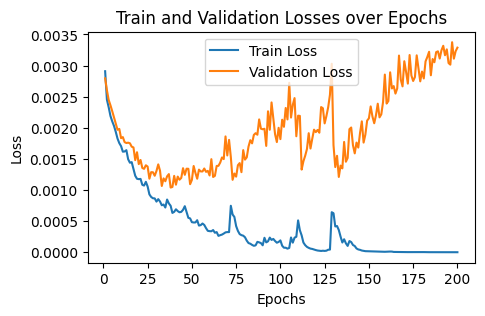

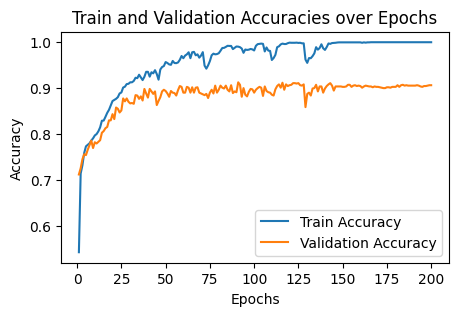

In [28]:
#Loss and accuracy plot
plot_losses(train_losses, valid_losses, config.EPOCH )
plot_accuracies(train_accuracies, valid_accuracies, config.EPOCH )

In [27]:
# 제일 성능이 좋은 모델 불러오기
model.load_state_dict(torch.load("/home/user/Desktop/bsh/absoluteA/model/4000_tcn_best_model.pth"))
Macro_f1, auroc, accuracy, all_labels, all_probabilities = test(model, test_loader)
print(f"Best epoch: {best_epoch_save}")
print(f"macro F1 Score: {Macro_f1}")
print(f"AUROC: {auroc}")
print(f"Accuracy: {accuracy}")

100%|██████████| 5/5 [00:02<00:00,  2.39it/s]

Best epoch: 91
macro F1 Score: 0.8697998977587207
AUROC: 0.9582193782960202
Accuracy: 0.8967684021543986


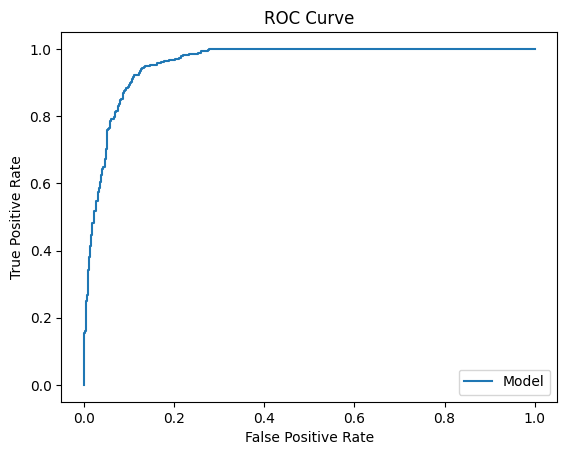

In [30]:
# AUROC plot
plot_roc_curve(all_labels, all_probabilities)